In this code, we will calculate new features as a combinarion of ratios between sleep details along with the activity count, and explore the relationship of these newly engineered features with MOOD of the participant. 

In [1]:

import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.regression.dimred import CORE
from scipy.linalg import eigh
from matplotlib.patches import Ellipse
from scipy.stats.distributions import chi2
from statsmodels.nonparametric.smoothers_lowess import lowess


C:\Users\rajnishk\AppData\Local\Temp\ipykernel_13784\976150565.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:

df_sleep = pd.read_csv(r'C:\Users\rajnishk\OneDrive - Michigan Medicine\Documents\Student Wellness Dataset\student_wellness_sleep_details.csv',
                 parse_dates=["SLEEP_DATE","SLEEP_START_DATE", "SLEEP_END_DATE"],index_col=0)

df_MOOD = pd.read_csv(r'C:\Users\rajnishk\OneDrive - Michigan Medicine\Documents\Student Wellness Dataset\df_MOOD_SWG.csv', 
                     parse_dates=["METRIC_START_DATE", "METRIC_END_DATE"],index_col=0)


In [3]:
df_MOOD.rename(columns={'METRIC_START_DATE': 'SLEEP_DATE'}, inplace=True) # So that I can merge two dataframes. 

In [4]:

sleep_vars = ['ASLEEP_VALUE', 'INBED_VALUE', 'DEEP_MIN', 'DEEP_COUNT', 'LIGHT_MIN', 'LIGHT_COUNT', 
              'REM_MIN', 'REM_COUNT', 'WAKE_MIN', 'WAKE_COUNT', 'ASLEEP_MIN', 'ASLEEP_COUNT', 
              'AWAKE_COUNT', 'AWAKE_MIN', 'RESTLESS_COUNT', 'RESTLESS_MIN']
v = df_sleep[sleep_vars].isna().sum(0)
v = v[v < 500].index.tolist()
vv = ["STUDY_PRTCPT_ID", "SLEEP_START_DATE", "SLEEP_END_DATE", "SLEEP_DATE"] + v
dx = df_sleep[vv].copy()
dx["YEARDAY"] = dx["SLEEP_DATE"].dt.dayofyear
dx["DAYOFWEEK"] = dx["SLEEP_DATE"].dt.dayofweek
dx["SLEEP_START_TIME"] = (dx["SLEEP_START_DATE"] - dx["SLEEP_START_DATE"].dt.normalize()) / pd.Timedelta(hours=1)
dx["SLEEP_END_TIME"] = (dx["SLEEP_END_DATE"] - dx["SLEEP_END_DATE"].dt.normalize()) / pd.Timedelta(hours=1)
dx["SLEEP_START_SIN"] = np.sin(2*np.pi*dx["SLEEP_START_TIME"]/24)
dx["SLEEP_START_COS"] = np.cos(2*np.pi*dx["SLEEP_START_TIME"]/24)
dx["SLEEP_END_SIN"] = np.sin(2*np.pi*dx["SLEEP_END_TIME"]/24)
dx["SLEEP_END_COS"] = np.cos(2*np.pi*dx["SLEEP_END_TIME"]/24)
dx["YEARDAY_SIN"] = np.sin(2*np.pi*dx["YEARDAY"]/366)
dx["YEARDAY_COS"] = np.cos(2*np.pi*dx["YEARDAY"]/366)

# #===============================================================================================
# dx["SLEEP_START_TIME"] = (dx["SLEEP_START_DATE"] - dx["SLEEP_START_DATE"].dt.normalize()) / pd.Timedelta(hours=1)
# plt.scatter(dx["SLEEP_START_TIME"],dx["SLEEP_START_SIN"] )
# #===============================================================================================


dx["STUDYDAY"] = dx["YEARDAY"] - dx.groupby("STUDY_PRTCPT_ID")["YEARDAY"].transform(np.min)
# dx = dx.drop(columns=["SLEEP_START_DATE", "SLEEP_END_DATE", "SLEEP_START_TIME", "SLEEP_END_TIME", "SLEEP_DATE"])
dx = dx.dropna()
dx.columns

C:\Users\rajnishk\AppData\Local\Temp\ipykernel_13784\105369829.py:25: FutureWarning: The provided callable <function min at 0x00000259CC5065F0> is currently using SeriesGroupBy.min. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "min" instead.
  dx["STUDYDAY"] = dx["YEARDAY"] - dx.groupby("STUDY_PRTCPT_ID")["YEARDAY"].transform(np.min)


Index(['STUDY_PRTCPT_ID', 'SLEEP_START_DATE', 'SLEEP_END_DATE', 'SLEEP_DATE',
       'ASLEEP_VALUE', 'INBED_VALUE', 'DEEP_MIN', 'DEEP_COUNT', 'LIGHT_MIN',
       'LIGHT_COUNT', 'REM_MIN', 'REM_COUNT', 'WAKE_MIN', 'WAKE_COUNT',
       'YEARDAY', 'DAYOFWEEK', 'SLEEP_START_TIME', 'SLEEP_END_TIME',
       'SLEEP_START_SIN', 'SLEEP_START_COS', 'SLEEP_END_SIN', 'SLEEP_END_COS',
       'YEARDAY_SIN', 'YEARDAY_COS', 'STUDYDAY'],
      dtype='object')

In [5]:
df_MOOD_sleep_polar = pd.merge(dx,df_MOOD, on = ['STUDY_PRTCPT_ID','SLEEP_DATE'], how = 'inner' )
df_MOOD_sleep_polar_MOOD_NZ = df_MOOD_sleep_polar[df_MOOD_sleep_polar.MOOD !=0]   # Lots of data goes away.

This is just to get everyone's attention. Check if SLEEP_COUNT and ASLEEP_VALUE are the same. 

In [6]:
abcd = df_MOOD_sleep_polar_MOOD_NZ.ASLEEP_VALUE - df_MOOD_sleep_polar_MOOD_NZ.SLEEP_COUNT
abcd[abcd!=0]

155    -178
156    -263
171     -53
178    -196
179    -269
       ... 
1734    -68
1735    -88
1737    -68
1746   -151
1757   -137
Length: 131, dtype: int64

In [7]:
# Normalizing the variables considered for analysis

In [8]:

columns_for_norm = ['ASLEEP_VALUE', 'INBED_VALUE', 'DEEP_MIN', 'DEEP_COUNT', 'LIGHT_MIN',
       'LIGHT_COUNT', 'REM_MIN', 'REM_COUNT', 'WAKE_MIN', 'WAKE_COUNT','STEP_COUNT', 'SLEEP_COUNT', 'MOOD']


# Normalize the sleep detail variables, total step variable, and MOOD. I am normalizing the MOOD because it is a part of factor analysis, and it might be interesting to see the appearance of MOOD in the vicinity of other sleep variables. 

df_MOOD_sleep_polar_MOOD_NZ_norm = df_MOOD_sleep_polar_MOOD_NZ.copy()
df_MOOD_sleep_polar_MOOD_NZ_norm[columns_for_norm] = df_MOOD_sleep_polar_MOOD_NZ_norm[columns_for_norm]- df_MOOD_sleep_polar_MOOD_NZ_norm[columns_for_norm].mean(0)
df_MOOD_sleep_polar_MOOD_NZ_norm[columns_for_norm] = df_MOOD_sleep_polar_MOOD_NZ_norm[columns_for_norm]/df_MOOD_sleep_polar_MOOD_NZ_norm[columns_for_norm].std(0)
df_MOOD_sleep_polar_MOOD_NZ_norm

,STUDY_PRTCPT_ID,SLEEP_START_DATE,SLEEP_END_DATE,SLEEP_DATE,ASLEEP_VALUE,INBED_VALUE,DEEP_MIN,DEEP_COUNT,LIGHT_MIN,LIGHT_COUNT,...,SLEEP_END_COS,YEARDAY_SIN,YEARDAY_COS,STUDYDAY,STUDY_METRIC_AGGREGATE_ID,STUDY_ID,STEP_COUNT,SLEEP_COUNT,MOOD,METRIC_END_DATE
0,XGJ8AFS8,2023-01-20 20:08:00,2023-01-21 05:48:30,2023-01-21,0.673706,0.844594,-0.079295,0.954446,0.867428,-0.151096,...,0.050157,0.352752,0.935717,0,4025733,401,-0.148212,0.314335,0.272990,2023-01-21
1,XGJ8AFS8,2023-01-21 20:33:30,2023-01-22 07:55:30,2023-01-22,1.544407,1.603654,-0.375125,1.618529,2.123036,1.387767,...,-0.482900,0.368763,0.929523,1,4031073,401,-0.055628,1.214312,0.823579,2023-01-22
2,XGJ8AFS8,2023-01-22 19:37:30,2023-01-23 07:07:30,2023-01-23,1.322464,1.663188,0.068619,0.954446,1.769515,1.387767,...,-0.290285,0.384665,0.923056,2,4036413,401,-0.130879,0.984906,0.272990,2023-01-23
3,XGJ8AFS8,2023-01-23 21:34:00,2023-01-24 06:02:30,2023-01-24,0.443226,0.308787,0.808193,0.290363,-0.071229,0.464449,...,-0.010908,0.400454,0.916317,3,4041773,401,-0.296177,0.076106,0.272990,2023-01-24
4,XGJ8AFS8,2023-01-24 20:20:30,2023-01-25 06:32:00,2023-01-25,0.733460,1.075288,-0.929805,0.290363,1.355043,0.361858,...,-0.139173,0.416125,0.909308,4,4047133,401,-0.813634,0.376098,0.272990,2023-01-25
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1779,3IJBZPI8,2023-04-13 23:23:00,2023-04-14 07:01:00,2023-04-14,-0.068951,-0.063302,-1.114699,1.618529,0.964951,0.669631,...,-0.263031,0.977064,-0.212947,43,4476751,401,-1.594469,-0.453293,0.272990,2023-04-14
1787,JU3R5P4M,2023-03-28 00:14:30,2023-03-28 05:33:30,2023-03-28,-1.221350,-1.097707,-1.706358,-1.037803,-0.729509,-0.766641,...,0.115371,0.997018,0.077175,1,4380458,401,-0.619165,-1.644439,-2.479951,2023-03-28
1788,JU3R5P4M,2023-03-29 01:38:30,2023-03-29 11:21:30,2023-03-29,0.639561,0.866919,-0.486061,-1.037803,1.720754,2.105903,...,-0.985923,0.998195,0.060049,2,4385858,401,-1.289871,0.279042,-1.378774,2023-03-29
1789,JU3R5P4M,2023-04-01 02:17:00,2023-04-01 18:04:00,2023-04-01,2.833387,3.575722,1.288917,1.618529,4.561108,3.747357,...,0.017452,0.999963,0.008583,5,4402280,401,-1.317774,2.546631,-1.929363,2023-04-01


In [9]:
# Calculate the ratio features as new features for factor analysis and machine learning for further analysis

In [10]:
features_for_ratios = ['ASLEEP_VALUE',  'INBED_VALUE',  'DEEP_MIN',  'DEEP_COUNT',  'LIGHT_MIN',  'LIGHT_COUNT',
 'REM_MIN',  'REM_COUNT',  'WAKE_MIN',  'WAKE_COUNT',  'STEP_COUNT',  'SLEEP_COUNT']
feature_remaining = ['MOOD']

In [11]:
# features_for_ratios

In [12]:
epsilon = 1e-10  # to avoid division by zero

In [13]:
X = df_MOOD_sleep_polar_MOOD_NZ_norm[features_for_ratios]
X_remain_feature = df_MOOD_sleep_polar_MOOD_NZ_norm[feature_remaining]

In [14]:
X_forward_ratios = X.copy()
X_reverse_ratios = X.copy()

In [15]:
X_reverse_ratios

,ASLEEP_VALUE,INBED_VALUE,DEEP_MIN,DEEP_COUNT,LIGHT_MIN,LIGHT_COUNT,REM_MIN,REM_COUNT,WAKE_MIN,WAKE_COUNT,STEP_COUNT,SLEEP_COUNT
0,0.673706,0.844594,-0.079295,0.954446,0.867428,-0.151096,0.261434,0.232651,1.469280,0.098242,-0.148212,0.314335
1,1.544407,1.603654,-0.375125,1.618529,2.123036,1.387767,0.446099,-0.004971,1.469280,1.198856,-0.055628,1.214312
2,1.322464,1.663188,0.068619,0.954446,1.769515,1.387767,0.208673,-0.242594,2.903869,0.923703,-0.130879,0.984906
3,0.443226,0.308787,0.808193,0.290363,-0.071229,0.464449,0.947333,0.707896,-0.429441,0.556831,-0.296177,0.076106
4,0.733460,1.075288,-0.929805,0.290363,1.355043,0.361858,-0.002373,0.232651,2.481931,0.189960,-0.813634,0.376098
...,...,...,...,...,...,...,...,...,...,...,...,...
1779,-0.068951,-0.063302,-1.114699,1.618529,0.964951,0.669631,-1.506075,-0.480216,-0.007503,-0.452065,-1.594469,-0.453293
1787,-1.221350,-1.097707,-1.706358,-1.037803,-0.729509,-0.766641,-0.978460,-0.480216,-0.176278,-0.635501,-0.619165,-1.644439
1788,0.639561,0.866919,-0.486061,-1.037803,1.720754,2.105903,-1.400552,-1.193084,1.764636,1.932599,-1.289871,0.279042
1789,2.833387,3.575722,1.288917,1.618529,4.561108,3.747357,-2.033689,-1.430706,6.279373,3.033213,-1.317774,2.546631


In [16]:
for i,feature1 in enumerate(features_for_ratios):
    for feature2 in features_for_ratios[i+1:]:
        X_forward_ratios[f'ratio_{feature1}_{feature2}'] = X_forward_ratios[feature1] / (X_forward_ratios[feature2] + epsilon)


In [17]:
for i,feature1 in enumerate(features_for_ratios):
    for feature2 in features_for_ratios[i+1:]:
        X_reverse_ratios[f'ratio_{feature2}_{feature1}'] = X_reverse_ratios[feature2] / (X_reverse_ratios[feature1] + epsilon)

In [18]:
df_final_forward_ratio = pd.concat([X_forward_ratios, X_remain_feature],axis=1)
df_final_forward_ratio

,ASLEEP_VALUE,INBED_VALUE,DEEP_MIN,DEEP_COUNT,LIGHT_MIN,LIGHT_COUNT,REM_MIN,REM_COUNT,WAKE_MIN,WAKE_COUNT,...,ratio_REM_COUNT_WAKE_COUNT,ratio_REM_COUNT_STEP_COUNT,ratio_REM_COUNT_SLEEP_COUNT,ratio_WAKE_MIN_WAKE_COUNT,ratio_WAKE_MIN_STEP_COUNT,ratio_WAKE_MIN_SLEEP_COUNT,ratio_WAKE_COUNT_STEP_COUNT,ratio_WAKE_COUNT_SLEEP_COUNT,ratio_STEP_COUNT_SLEEP_COUNT,MOOD
0,0.673706,0.844594,-0.079295,0.954446,0.867428,-0.151096,0.261434,0.232651,1.469280,0.098242,...,2.368152,-1.569722,0.740139,14.955761,-9.913377,4.674251,-0.662847,0.312539,-0.471509,0.272990
1,1.544407,1.603654,-0.375125,1.618529,2.123036,1.387767,0.446099,-0.004971,1.469280,1.198856,...,-0.004147,0.089365,-0.004094,1.225568,-26.412740,1.209969,-21.551426,0.987272,-0.045810,0.823579
2,1.322464,1.663188,0.068619,0.954446,1.769515,1.387767,0.208673,-0.242594,2.903869,0.923703,...,-0.262632,1.853576,-0.246312,3.143727,-22.187478,2.948372,-7.057698,0.937859,-0.132885,0.272990
3,0.443226,0.308787,0.808193,0.290363,-0.071229,0.464449,0.947333,0.707896,-0.429441,0.556831,...,1.271295,-2.390110,9.301501,-0.771223,1.449946,-5.642699,-1.880060,7.316558,-3.891663,0.272990
4,0.733460,1.075288,-0.929805,0.290363,1.355043,0.361858,-0.002373,0.232651,2.481931,0.189960,...,1.224741,-0.285941,0.618592,13.065573,-3.050427,6.599162,-0.233471,0.505080,-2.163357,0.272990
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1779,-0.068951,-0.063302,-1.114699,1.618529,0.964951,0.669631,-1.506075,-0.480216,-0.007503,-0.452065,...,1.062271,0.301176,1.059396,0.016597,0.004706,0.016552,0.283521,0.997293,3.517527,0.272990
1787,-1.221350,-1.097707,-1.706358,-1.037803,-0.729509,-0.766641,-0.978460,-0.480216,-0.176278,-0.635501,...,0.755650,0.775587,0.292024,0.277385,0.284703,0.107197,1.026384,0.386455,0.376521,-2.479951
1788,0.639561,0.866919,-0.486061,-1.037803,1.720754,2.105903,-1.400552,-1.193084,1.764636,1.932599,...,-0.617347,0.924963,-4.275649,0.913090,-1.368071,6.323919,-1.498288,6.925846,-4.622506,-1.378774
1789,2.833387,3.575722,1.288917,1.618529,4.561108,3.747357,-2.033689,-1.430706,6.279373,3.033213,...,-0.471680,1.085700,-0.561804,2.070205,-4.765138,2.465757,-2.301771,1.191069,-0.517458,-1.929363


In [19]:
df_final_reverse_ratio = pd.concat([X_reverse_ratios, X_remain_feature],axis=1)
df_final_reverse_ratio

,ASLEEP_VALUE,INBED_VALUE,DEEP_MIN,DEEP_COUNT,LIGHT_MIN,LIGHT_COUNT,REM_MIN,REM_COUNT,WAKE_MIN,WAKE_COUNT,...,ratio_WAKE_COUNT_REM_COUNT,ratio_STEP_COUNT_REM_COUNT,ratio_SLEEP_COUNT_REM_COUNT,ratio_WAKE_COUNT_WAKE_MIN,ratio_STEP_COUNT_WAKE_MIN,ratio_SLEEP_COUNT_WAKE_MIN,ratio_STEP_COUNT_WAKE_COUNT,ratio_SLEEP_COUNT_WAKE_COUNT,ratio_SLEEP_COUNT_STEP_COUNT,MOOD
0,0.673706,0.844594,-0.079295,0.954446,0.867428,-0.151096,0.261434,0.232651,1.469280,0.098242,...,0.422270,-0.637056,1.351098,0.066864,-0.100874,0.213938,-1.508644,3.199606,-2.120848,0.272990
1,1.544407,1.603654,-0.375125,1.618529,2.123036,1.387767,0.446099,-0.004971,1.469280,1.198856,...,-241.161157,11.190032,-244.270198,0.815948,-0.037861,0.826467,-0.046401,1.012892,-21.829266,0.823579
2,1.322464,1.663188,0.068619,0.954446,1.769515,1.387767,0.208673,-0.242594,2.903869,0.923703,...,-3.807611,0.539498,-4.059899,0.318094,-0.045070,0.339170,-0.141689,1.066259,-7.525332,0.272990
3,0.443226,0.308787,0.808193,0.290363,-0.071229,0.464449,0.947333,0.707896,-0.429441,0.556831,...,0.786600,-0.418391,0.107510,-1.296641,0.689681,-0.177220,-0.531898,0.136676,-0.256960,0.272990
4,0.733460,1.075288,-0.929805,0.290363,1.355043,0.361858,-0.002373,0.232651,2.481931,0.189960,...,0.816499,-3.497224,1.616573,0.076537,-0.327823,0.151534,-4.283194,1.979884,-0.462245,0.272990
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1779,-0.068951,-0.063302,-1.114699,1.618529,0.964951,0.669631,-1.506075,-0.480216,-0.007503,-0.452065,...,0.941379,3.320315,0.943934,60.250645,212.508577,60.414195,3.527076,1.002714,0.284291,0.272990
1787,-1.221350,-1.097707,-1.706358,-1.037803,-0.729509,-0.766641,-0.978460,-0.480216,-0.176278,-0.635501,...,1.323365,1.289346,3.424371,3.605102,3.512429,9.328652,0.974294,2.587625,2.655897,-2.479951
1788,0.639561,0.866919,-0.486061,-1.037803,1.720754,2.105903,-1.400552,-1.193084,1.764636,1.932599,...,-1.619835,1.081124,-0.233883,1.095183,-0.730956,0.158130,-0.667428,0.144387,-0.216333,-1.378774
1789,2.833387,3.575722,1.288917,1.618529,4.561108,3.747357,-2.033689,-1.430706,6.279373,3.033213,...,-2.120081,0.921065,-1.779981,0.483044,-0.209858,0.405555,-0.434448,0.839582,-1.932525,-1.929363


# # PCA/biplots

In [20]:
# EITHER PICK THIS PAIR
# dx = df_final_forward_ratio
# va = df_final_forward_ratio.columns  


# OR THIS PAIR 
dx = df_final_reverse_ratio
va = df_final_reverse_ratio.columns

In [21]:
def plot_eigs(eigs):
    jj = np.arange(1, len(eigs) + 1)
    ii = np.flatnonzero(eigs >= 1e-10)
    plt.clf()
    plt.grid(True)
    plt.plot(np.log(jj[ii]), np.log(eigs[ii]), "-o")
    # plt.plot((jj[ii]), (eigs[ii]), "-o")
    
    plt.ylabel("Log eigenvalue", size=15)
    plt.xlabel("Log position", size=15)
    plt.show()

In [22]:
def varimax(X, eps=1e-05, maxiter=1000):
    G = X.copy()
    m, p = G.shape
    Q = np.eye(p)
    if p < 2: 
        return G, Q
    d = 0.0
    for i in range(maxiter):
        z = np.dot(G, Q)
        cs = (z**2).sum(0)
        B = np.dot(G.T, z**3 - z * (cs / m))
        u, s, vt = np.linalg.svd(B, 0)
        Q = np.dot(u, vt)
        dlast = d
        d = s.sum()
        if d < dlast * (1 + eps): 
            break
            
    G = np.dot(G, Q)
    return G, Q

In [23]:
def ellipse_plot(U, idx, j0, j1):
    r2 = chi2(2).ppf(0.95)
    rr = np.sqrt(r2)
    dx = pd.DataFrame({"u0": U[:, 0], "u1": U[:, 1], "id": idx})
    plt.clf()
    plt.figure(figsize=(10, 10))
    plt.grid(True)
    plt.plot(dx["u0"], dx["u1"], "o", color="black", alpha=0.05)
    for (ky,dg) in dx.groupby("id"):
        if dg.shape[0] > 10:
            m0, m1 = dg["u0"].mean(), dg["u1"].mean()
            C = np.cov(dg["u0"], dg["u1"])
            a, b = eigh(C)
            plt.plot([m0], [m1], "o", color="blue", ms=8, alpha=0.2)
            ang = np.arctan2(b[1, 1], b[0, 1])*360/(2*np.pi)
            E = Ellipse(xy=[m0,m1], width=rr*np.sqrt(a[1]), height=rr*np.sqrt(a[0]), fc="none", ec="black", angle=ang)
            plt.gca().add_artist(E)
    plt.xlabel("Component %d" % j0, size=17)
    plt.ylabel("Component %d" % j1, size=17)
    plt.show()

va is Index(['ASLEEP_VALUE', 'INBED_VALUE', 'DEEP_MIN', 'DEEP_COUNT', 'LIGHT_MIN',
       'LIGHT_COUNT', 'REM_MIN', 'REM_COUNT', 'WAKE_MIN', 'WAKE_COUNT',
       'STEP_COUNT', 'SLEEP_COUNT', 'ratio_INBED_VALUE_ASLEEP_VALUE',
       'ratio_DEEP_MIN_ASLEEP_VALUE', 'ratio_DEEP_COUNT_ASLEEP_VALUE',
       'ratio_LIGHT_MIN_ASLEEP_VALUE', 'ratio_LIGHT_COUNT_ASLEEP_VALUE',
       'ratio_REM_MIN_ASLEEP_VALUE', 'ratio_REM_COUNT_ASLEEP_VALUE',
       'ratio_WAKE_MIN_ASLEEP_VALUE', 'ratio_WAKE_COUNT_ASLEEP_VALUE',
       'ratio_STEP_COUNT_ASLEEP_VALUE', 'ratio_SLEEP_COUNT_ASLEEP_VALUE',
       'ratio_DEEP_MIN_INBED_VALUE', 'ratio_DEEP_COUNT_INBED_VALUE',
       'ratio_LIGHT_MIN_INBED_VALUE', 'ratio_LIGHT_COUNT_INBED_VALUE',
       'ratio_REM_MIN_INBED_VALUE', 'ratio_REM_COUNT_INBED_VALUE',
       'ratio_WAKE_MIN_INBED_VALUE', 'ratio_WAKE_COUNT_INBED_VALUE',
       'ratio_STEP_COUNT_INBED_VALUE', 'ratio_SLEEP_COUNT_INBED_VALUE',
       'ratio_DEEP_COUNT_DEEP_MIN', 'ratio_LIGHT_MIN_DEEP_MIN',
     

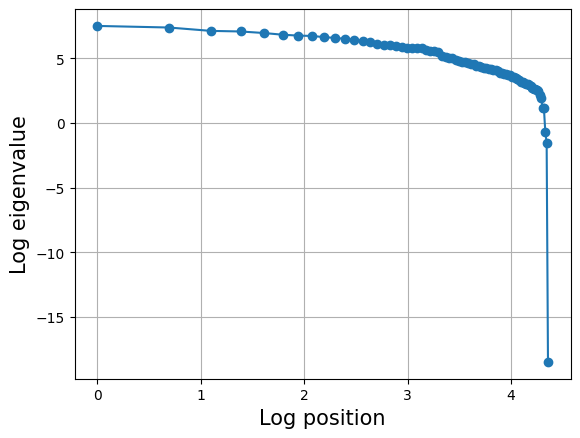

<Figure size 640x480 with 0 Axes>

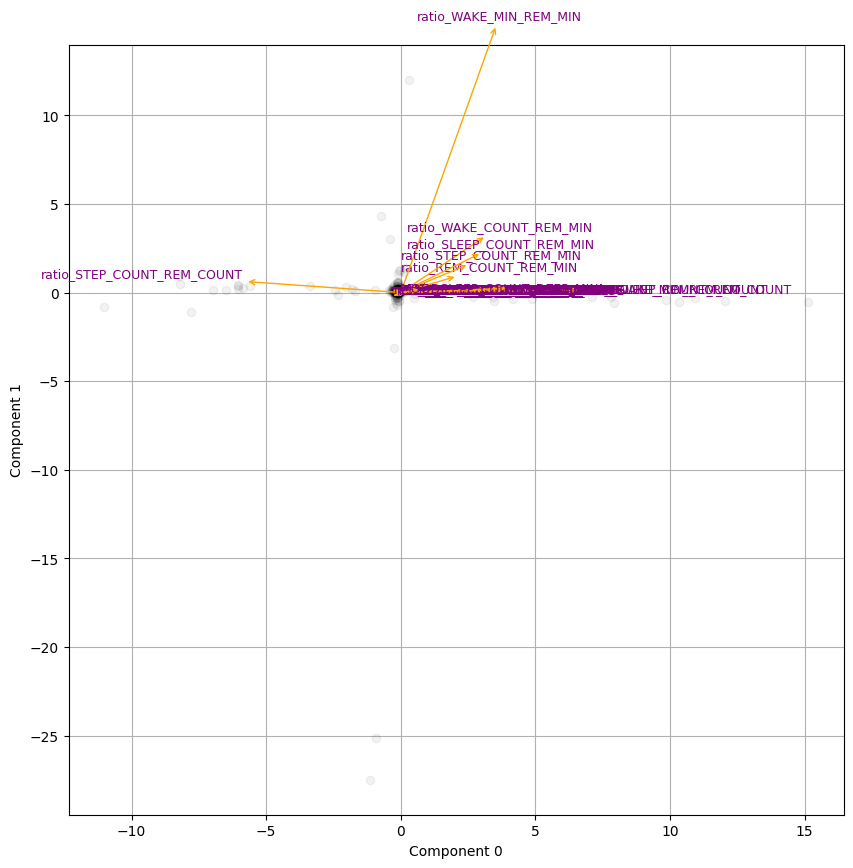

KeyError: 'STUDY_PRTCPT_ID'

In [24]:

def biplot(dx, va, j=0, k=1, d=5, rotate=False, scree=False, ellipses=False):
    assert d > max(j, k)
    dx = dx.copy()
    X = np.asarray(dx[va])
    n, p = X.shape
    X -= X.mean()
    X -= X.mean(0)
    u, s, vt = np.linalg.svd(X, 0)
    v = vt.T
    if scree:
        plot_eigs(s)
    uu = u[:, 0:d]
    vv = v[:, 0:d]
    ss = s[0:d]
    if rotate:
        uu, Ru = varimax(uu)
        uu *= np.sqrt(n)
        vv, Rv = varimax(vv)
        vv *= np.sqrt(p)
        B = np.dot(Ru.T * ss, Rv) / np.sqrt(n*p)
    else:
        uu *= (ss**0.5)
        vv *= (ss**0.5)
        B = np.eye(d)
        
    ff = np.sqrt(X.shape[0] / X.shape[1]) # May need to adjust this
    v /= ff
    plt.clf()
    plt.figure(figsize=(10, 10))
    plt.grid(True)
    plt.plot(uu[:, j], uu[:, k], "o", color="black", alpha=0.05)
    for i in range(v.shape[0]):
        
        plt.annotate(va[i], xy=(0, 0), xytext=(vv[i, j], vv[i, k]), 
                     arrowprops=dict(color='orange', arrowstyle="<-"), color="purple", size=9)
    plt.xlabel("Component %d" % j)
    plt.ylabel("Component %d" % k)
    plt.show()
    
    if ellipses:
        ellipse_plot(uu[:, [j, k]], dx["STUDY_PRTCPT_ID"], j,k)
print("va is %s" %va)        
biplot(dx, va, 0, 1, d=5, rotate=False, scree=True, ellipses=True)
biplot(dx, va, 2, 3, d=5, rotate=False, ellipses=True)
biplot(dx, va, 0, 1, d=5, rotate=True, ellipses=True)
biplot(dx, va, 2, 3, d=5, rotate=True, ellipses=True)